In [91]:
#!g1.1
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T

from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import train_test_split

In [92]:
class EmbeddingsDataset(Dataset):
    def __init__(self, features, text, labels, train):
        assert len(features) == len(text) == len(labels)
        # self.features = features
        self.labels = labels.tolist()
        self.text = text


        embeddings_ds = TensorDataset(
            features, 
            labels
        ) 
        train_idx, val_idx = train_test_split(
            list(range(len(embeddings_ds))), test_size=.1, shuffle=True
        )
        if train == -1:
            self.ds = embeddings_ds
        else:
            self.ds = Subset(embeddings_ds, train_idx) if train else Subset(embeddings_ds, val_idx)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index):
        data = self.ds[index][0]
        _class = self.ds[index][1]
        return (data, _class)

    def get_text_by_labels(self, lbl):
        _dict = {self.labels[i]: self.text[i] for i in range(len(self.labels))}

        return np.vectorize(_dict.get)(lbl) if isinstance(lbl, (list, np.ndarray)) else _dict[lbl]



In [93]:
# txt_labels = np.load(r'C:\Users\grokh\Desktop\StartML\Final Project\startMLapp\emb_labels.npy', allow_pickle=True)

# num_labels = np.load(r'C:\Users\grokh\Desktop\StartML\Final Project\startMLapp\emb_num_labels.npy')
# num_labels = torch.Tensor(num_labels)

# embdict = np.load(r'.\embeddings\embdict_2.npy', allow_pickle=True).item()
# embeddings = torch.Tensor(embdict['mean_pooling__identity']) # take 'max_pooling__identity' as default example

# ED = EmbeddingsDataset(embeddings, labels, num_labels, train=True)

In [94]:
# train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
# valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)
# full_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=-1)

# train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
# valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

## Prepare

In [95]:
#!g1.1
def train(
    model, optimizer, loss_fn, device
):
    model.train()
    model.to(device)

    if isinstance(model, DEC):
        if not model.initialized:
            xs = []
            ys = []
            
            static_loader = DataLoader(
                train_dataset,
                batch_size=256,
                pin_memory=False,
                shuffle=False,
            )

            for x, y in tqdm(static_loader, desc='Initialization of cluster centers'):
                x, y = x.to(device), y.to(device)
                xs.append(model.encoder(x).detach().cpu())
                ys.append(y)

            xs = torch.cat(xs)
            ys = torch.cat(ys)

            with torch.no_grad():
                model.kmeans.fit(xs)

                model.state_dict()["assignment.centroids"].copy_(
                    torch.tensor(model.kmeans.cluster_centers_)
                )

                model.init_acc = cluster_acc(ys.cpu().numpy(), model.kmeans.labels_)

                print('Initial accuracy:', model.init_acc)

                model.y_pred_previous_initiialized = False # necessary for delta initialization 
                    
            model.initialized = True
            print('Centroids weights were initialized.')

    train_loss = 0
    ys = []
    outputs = []
    counter = 0

    for x, y in tqdm(train_loader, desc='Train'):
        
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        if isinstance(model, DEC):
        
            if type(model) == DEC:
                q = model(x)
                p = model.get_target_distribution(q).detach()
                
                # output = q
                # y_pred = q.argmax(1)
                loss = loss_fn(q.log(), p)
                
            elif type(model) == IDEC:
                
                q, output = model(x)
                p = model.get_target_distribution(q).detach()

                loss = loss_fn(
                    q.log(), p,
                    output, x
                )

            ys.append(y)
            outputs.append(q.cpu().detach().argmax(1)) 

        elif isinstance(model, StackedAutoEncoder):
            output = model(x)
            loss = loss_fn(output, x)
        
        else:
            raise TypeError("Received model type is not supported. Use StackedAutoEncoder, StackedDenoisingAutoEncoder, DEC or IDEC")
        
        train_loss += loss.item()

        loss.backward()
        optimizer.step(closure=None)

    train_loss /= len(train_loader)

    if isinstance(model, DEC):
        
        y = torch.cat(ys).cpu().numpy()
        y_pred = torch.cat(outputs).numpy()

        return (
            train_loss,
            y, 
            y_pred,
        )
    elif isinstance(model, StackedAutoEncoder):
        return train_loss


In [96]:
#!g1.1
@torch.inference_mode()
def evaluate(
    model, loader, loss_fn, device
):
    model.eval()

    eval_loss = 0

    outputs = []
    ys = []

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)


        if isinstance(model, DEC):
            if type(model) == DEC:

                q = model(x)
                p = model.get_target_distribution(q).detach()
                
                loss = loss_fn(q.log(), p)
                
            elif type(model) == IDEC:
                q, output = model(x)
                p = model.get_target_distribution(q).detach()
                
                loss = loss_fn(
                    q.log(), p,
                    output, x
                )

            ys.append(y)
            outputs.append(q.cpu().detach().argmax(1))

        elif isinstance(model, StackedAutoEncoder):
            output = model(x)
            loss = loss_fn(output, x)

        else:
            raise TypeError("Received model type is not supported. Use StackedAutoEncoder, StackedDenoisingAutoEncoder, DEC or IDEC")

        eval_loss += loss.item()

    eval_loss /= len(loader)


    if isinstance(model, DEC):
        with torch.no_grad():
            y = torch.cat(ys).cpu().numpy()
            y_pred = torch.cat(outputs).numpy()
            
        return (
            eval_loss,
            y,
            y_pred
        )
    elif isinstance(model, StackedAutoEncoder):
        return eval_loss
        

In [97]:
from typing import List

def plot_stats(
    train_loss: List[float],
    valid_loss: List[float],
    title: str
):
    plt.figure(figsize=(10, 5))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()
    
    plt.show()


def plot_stats_dec(
    train_loss: List[float],
    valid_loss: List[float],

    train_acc: List[float],
    train_nmi: List[float],
    train_ari: List[float],
    val_acc: List[float],
    val_nmi: List[float],
    val_ari: List[float],

    title: str
):
    plt.figure(figsize=(10, 5))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(10, 5))

    plt.title(title + " cluster accuracy, normalized mutual info score, adjusted random info score")

    plt.plot(train_acc, label="Train acc", linewidth=1.5)
    plt.plot(train_nmi, label="Train nmi", linestyle='dashdot')
    plt.plot(train_ari, label="Train ari", linestyle='dashed')

    plt.plot(val_acc, label="Valid acc", linewidth=1.5)
    plt.plot(val_nmi, label="Valid nmi", linestyle='dashdot')
    plt.plot(val_ari, label="Valid ari", linestyle='dashed')

    plt.legend()
    plt.grid()

    plt.show()

def plot_stats_idec(
    train_loss: List[float],
    valid_loss: List[float],
    
    train_rec_loss: List[float],
    
    train_cl_loss: List[float],

    train_acc: List[float],
    train_nmi: List[float],
    train_ari: List[float],
    val_acc: List[float],
    val_nmi: List[float],
    val_ari: List[float],

    title: str
):
    plt.figure(figsize=(10, 5))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
        
    plt.plot(train_rec_loss, label="Train Reconstruct. loss",linestyle='dashdot')
    plt.plot(train_cl_loss, label="Train Clustering loss",linestyle='dashed')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(10, 5))

    plt.title(title + " cluster accuracy, normalized mutual info score, adjusted random info score")

    plt.plot(train_acc, label="Train acc", linewidth=2)
    plt.plot(train_nmi, label="Train nmi", linestyle='dashdot')
    plt.plot(train_ari, label="Train ari", linestyle='dashed')

    plt.plot(val_acc, label="Valid acc", linewidth=2)
    plt.plot(val_nmi, label="Valid nmi", linestyle='dashdot')
    plt.plot(val_ari, label="Valid ari", linestyle='dashed')

    plt.legend()
    plt.grid()

    plt.show()
    

In [98]:
def whole_train_valid_cycle(
    model, scheduler, optimizer, loss_fn, device, title,
    num_epochs:int = 100, 
    patience_threshold:tuple = (None, None),
    save_best_params_as:str = None
):
    train_loss_history, valid_loss_history = [], []
    
    best_valid_loss = np.inf
    
    patience =0

    train_acc_history, train_nmi_history, train_ari_history = [], [], []
    val_acc_history, val_nmi_history, val_ari_history = [], [], []
    
    if type(model) == IDEC:
        train_rec_loss_history, train_cl_loss_history = [], []
        valid_rec_loss_history, valid_cl_loss_history = [], []

    for epoch in range(num_epochs):

        if isinstance(model, DEC):

            train_loss, train_y, train_y_pred, = train(model, optimizer, loss_fn, device)
            valid_loss, val_targets, val_predicted = evaluate(model, valid_loader, loss_fn, device)
            
            if type(model) == IDEC:

                train_rec_loss, train_cl_loss = train_loss['rec'], train_loss['clust']
                train_loss = train_loss['total']
                
                
                train_rec_loss_history.append(train_rec_loss)
                train_cl_loss_history.append(train_cl_loss)
                
                
    
            train_acc = cluster_acc(train_y, train_y_pred)
            train_nmi = normalized_mutual_info_score(train_y, train_y_pred)
            train_ari = adjusted_rand_score(train_y, train_y_pred)

            train_acc_history.append(train_acc)
            train_nmi_history.append(train_nmi)
            train_ari_history.append(train_ari)

            val_acc = cluster_acc(val_targets, val_predicted)
            val_nmi = normalized_mutual_info_score(val_targets, val_predicted)
            val_ari = adjusted_rand_score(val_targets, val_predicted)

            val_acc_history.append(val_acc)
            val_nmi_history.append(val_nmi)
            val_ari_history.append(val_ari)
        
 
        elif isinstance(model, StackedAutoEncoder):
            train_loss = train(model, optimizer, loss_fn, device)
            valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        print('patience:',patience)
        if patience_threshold[0] is not None and len(valid_loss_history)>1:
            if round(valid_loss_history[-2], patience_threshold[1]) == round(valid_loss, patience_threshold[1]):
                patience += 1
            else:
                patience = 0

            
            if patience == patience_threshold[0]:
                print('Training stopped. Patience threshold was reached')
                print(f'Fin train loss:', train_loss)
                print(f'Fin valid loss:', valid_loss)
                break


        clear_output(wait=True)
        

        if isinstance(model, DEC):
            if type(model) == DEC:
                plot_stats_dec(
                    train_loss_history, valid_loss_history, 
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )
            if type(model) == IDEC:
                plot_stats_idec(
                    train_loss_history, valid_loss_history, 
                    train_rec_loss_history, 
                    train_cl_loss_history,
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )

        elif isinstance(model, StackedAutoEncoder):
            plot_stats(
                train_loss_history, valid_loss_history,
                title
            )

            # scheduler only for autoencoder
            scheduler.step() if not scheduler == None else None


        if not save_best_params_as == None:
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), save_best_params_as)
                print(f"Model parameters saved to '{save_best_params_as}'")                  
        

            

## Net

In [99]:
#!g1.1
class Block(nn.Module):
    def __init__(
        self, 
        inp_dim: int, 
        out_dim: int,
        activation: nn.Module,
        dropout_value: float
    ):
        super().__init__()
        self.fc1 = nn.Linear(inp_dim, out_dim)
        self.act = activation()
        self.dropout = nn.Dropout(dropout_value)
        # self.get_value_for_p = dropout_value
 
    def forward(self, x):
        return self.dropout(
            self.act(self.fc1(x))
        )

class StackedAutoEncoder(nn.Module):
    def __init__(
        self, 
        dims:list, 
        activation:nn.Module = nn.ReLU,
        dropout_value:float = .0,
        base_block:nn.Module = Block,
    ):
        """
        Fully connected auto-encoder model, symmetric.
        Arguments:
            dims: list of number of units in each layer of encoder. dims[0] is input dims, dims[-1] is units in hidden layer.
                The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
            act: activation, not applied to Input, Hidden and Output layers
        return:
            Model of autoencoder
        """
        super().__init__()
        self.dims = dims
        self.inp_dim = dims[0]
        self.hid_dim = dims[-1]
        self.dropout_value = dropout_value
        self.activation = activation

        # encoder creation
        encoder_blocks = []

        encoder_blocks.extend([
            base_block(self.inp_dim, dims[1], nn.Identity, dropout_value),
            base_block(dims[1], dims[2], activation, dropout_value),
            base_block(dims[2], dims[3], activation, dropout_value),
            base_block(dims[3], self.hid_dim, nn.Identity, dropout_value),
        ])

        self.encoder = nn.Sequential(*encoder_blocks)  

        decoder_blocks = []
        decoder_blocks.extend([
            base_block(self.hid_dim, dims[3], activation, dropout_value),
            base_block(dims[3], dims[2], activation, dropout_value),
            base_block(dims[2], dims[1], activation, dropout_value),
            base_block(dims[1], self.inp_dim, nn.Identity, dropout_value), #nn.Identity f(x)==x
        ])
        
        self.decoder = nn.Sequential(*decoder_blocks) 


    def set_dropout_value(self, value:float):
        self.dropout_value = value

        for i in range(len(self.encoder)):
            self.encoder[i].dropout.p = self.dropout_value
        for i in range(len(self.decoder)):
            self.decoder[i].dropout.p = self.dropout_value


    def forward(self, x):
        self.set_dropout_value(self.dropout_value) # inplace

        return self.decoder(self.encoder(x))



In [100]:
class DenoisingBlock(Block):
    def __init__(
        self, 
        inp_dim: int, 
        out_dim: int,
        activation: nn.Module,
        dropout_value: float
    ):
        super().__init__(inp_dim, out_dim, activation, dropout_value)
                
    def forward(self, x):
        if self.training:
            x = x + torch.randn_like(x) * 0.01

        return self.act(
            self.dropout(self.fc1(x))
        )


class StackedDenoisingAutoEncoder(StackedAutoEncoder):
    def __init__(
        self, 
        dims:list, 
        activation: nn.Module = nn.ReLU,
        dropout_value: float = .0,
        base_block: nn.Module = DenoisingBlock,
    ):
        super().__init__(dims, activation, dropout_value, base_block,)

    def forward(self, x):
        if self.training:
            x = torch.clip(x + torch.randn_like(x) * 0.1, min=0, max=1)

        return self.decoder(self.encoder(x))


In [101]:
from sklearn.cluster import KMeans

class ClusterAssignment(nn.Module):
    def __init__(
        self,
        num_cluster: int,
        hidden_dim: int,
        alpha: float = 1.0,
        centroids: torch.tensor = None,
    ):
        """ 
        student t-distribution, as same as used in t-SNE algorithm.
                    q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            num_cluster: 
            hidden_dim: 
            alpha:
            centroids:
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        super().__init__()
        self.num_cluster = num_cluster
        self.hidden_dim = hidden_dim
        self.alpha = alpha
        self.centroids = centroids

        
        if centroids is None:
            centroids = torch.zeros(
                self.num_cluster, self.hidden_dim, dtype=torch.float
            )
            nn.init.xavier_uniform_(centroids)

        self.centroids = nn.Parameter(centroids)


    def forward(self, z):
        z, self.centroids = z.to(device), self.centroids.to(device)
        diff = torch.sum((z.unsqueeze(1) - self.centroids) ** 2, 2)
        numerator = 1.0 / (1.0 + (diff / self.alpha))
        power = (self.alpha + 1.0) / 2
        numerator = numerator ** power
        q = numerator / torch.sum(numerator, dim=1, keepdim=True)
        return q


class DEC(nn.Module):
    def __init__(
        self, 
        autoencoder: nn.Module,
        n_clusters: int = 10,
        alpha: float = 1.0,
        centroids = None,
    ):
        '''
        Deep Embedded Clustering
        '''
        super().__init__()
        self.encoder = autoencoder.encoder
        self.n_clusters = n_clusters
        self.hidden_dim = autoencoder.hid_dim
        self.alpha = alpha

        self.assignment = ClusterAssignment(
            n_clusters, autoencoder.hid_dim, alpha, centroids
        )
        self.kmeans = KMeans(n_clusters, random_state=0, n_init=20)
        self.initialized = False
        

    def forward(self, x):
        return self.assignment(self.encoder(x))

    def get_target_distribution(self, q):
        numerator = (q ** 2) / torch.sum(q, 0)
        p = (numerator.t() / torch.sum(numerator, 1)).t()
        return p


class IDEC(DEC):
    def __init__(
        self, 
        autoencoder: nn.Module,
        n_clusters: int = 10,
        alpha: float = 1.0,
    ):    
        super().__init__(
            autoencoder,
            n_clusters,
            alpha,
            # None,
        ) 
        self.decoder = autoencoder.decoder
   
    
    def forward(self, x):
        return(
            self.assignment(self.encoder(x)),
            self.decoder(self.encoder(x))
        )
    

In [102]:
from scipy.optimize import linear_sum_assignment 
    
def cluster_acc(y_true, y_pred, reassign:bool = False):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    reassignment = dict(zip(row_ind, col_ind))

    if reassign:
        return (
            reassignment,
            w[row_ind, col_ind].sum() / y_pred.size
        )
    else:
        return w[row_ind, col_ind].sum() / y_pred.size
        

In [103]:
class IDEC_loss(nn.Module):
    def __init__(self, gamma=.1):
        super().__init__();
        self.gamma = gamma

    def forward(self, pred_cl, targ_cl, pred_rec, targ_rec, ):
        """
        See original paper for explanation
        """
        loss_cl = nn.KLDivLoss(reduction='batchmean')
        loss_rec = nn.MSELoss()

        self.rec_loss = loss_rec(pred_rec, targ_rec)
        self.cl_loss = loss_cl(pred_cl, targ_cl)
        return self.rec_loss + self.gamma * self.cl_loss
    

In [104]:
def predict_cluster_accuracy(model, loader):
    model.to(device)
    targets, predicted = [], []
    for x, y in tqdm(loader, desc='Evaluate cluster accuracy'):
        x, y = x.to(device), y.to(device)
        output = model(x)

        y_pred = output.argmax(1)

        targets.append(y)
        predicted.append(y_pred)

    targets = torch.cat(targets).cpu().numpy()
    predicted = torch.cat(predicted).cpu().numpy()

    reassignment, accuracy = cluster_acc(targets, predicted, reassign=True)
    return (reassignment, accuracy, predicted)


## Initialize

In [105]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla P100-PCIE-16GB


# Dataset Augmentation

First of all, we should get a clear picture of what we want to get from our augmentation. In practice of unsupervised learning:
- We do not know which sample correlates to which class *a priori*
- But we do have initial guess of how many KMeans clusters do we have (n_clusters=7)
- To solve the problem of imbalanced classes during augmentation, we can somehow regularize augmentation of dominant classes (using intial cluster guess). Let's try to implement this idea.

In [17]:
txt_labels = np.load(r'/kaggle/input/embaug-dataset/embaug_txt_labels.npy', allow_pickle=True)

# np.save('./embeddings/embaug_txt_labels.npy', txt_labels)
# np.save('./embeddings/embaug_num_labels.npy', num_labels)

num_labels = np.load(r'/kaggle/input/embaug-dataset/embaug_num_labels.npy')
num_labels = torch.Tensor(num_labels)

# embaug_dict = np.load(r'.\embeddings\embaug_dict.npy', allow_pickle=True).item()

#### num. 6 'mean_pooling__layer'

In [52]:
embeddings = torch.Tensor(np.load(r'/kaggle/input/embaug-dataset/embaug_meanpooling_layer.npy'))

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

### Getting baseline KMeans score

In [25]:
# km_baseline = KMeans(n_clusters=7, random_state=0, n_init=20).fit_predict(embeddings)

# cluster_acc(
#     num_labels.numpy(),
#     km_baseline
# )

0.5548625943329062

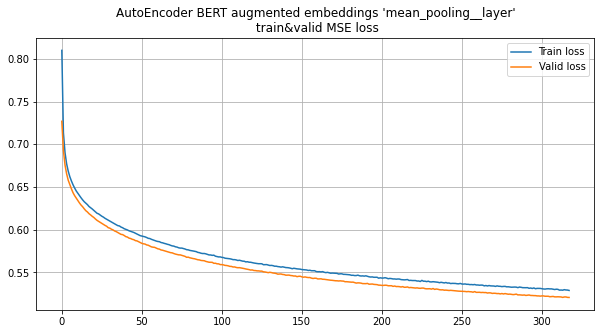

Model parameters saved to './bertembaug_train_6.pt'


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 86.99it/s]

patience: 9
Training stopped. Patience threshold was reached
Fin train loss: 0.5295863236010316
Fin valid loss: 0.5206314921379089


In [29]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.003)

optimizer = Adam(model.parameters(), lr=1e-4, )
# scheduler = StepLR(optimizer, step_size=100, gamma=10) 
# scheduler = MultiStepLR(optimizer, milestones=[50, 500], gamma=10)


whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 4),
    save_best_params_as = './bertembaug_train_6.pt',
    title="AutoEncoder BERT augmented embeddings 'mean_pooling__layer'\n train&valid MSE"
)

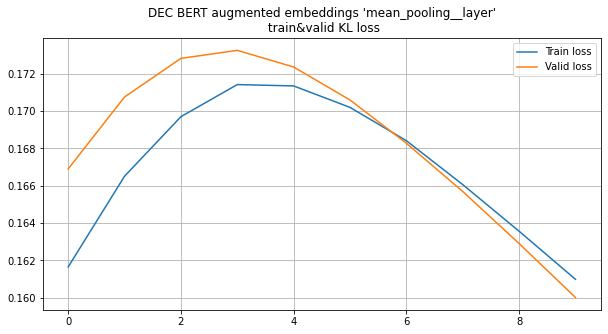

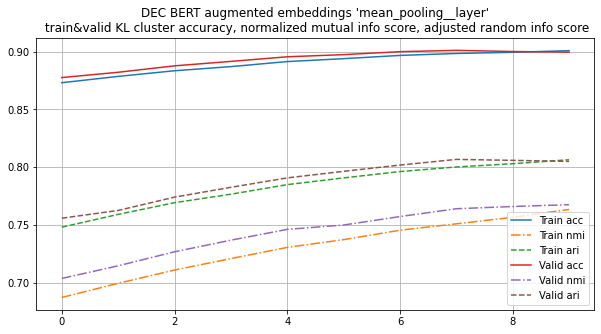

In [62]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.01)
model.load_state_dict(torch.load(r'/kaggle/working/bertembaug_train_6.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-6)
# optimizer = SGD(dec.parameters(), lr=.0001, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.01)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 10,
    # patience_threshold=10,
    device = device,
#     save_best_params_as='bertembaug_dec_weights_6.pt',
    title="DEC BERT augmented embeddings 'mean_pooling__layer'\n train&valid KL"
)


In [68]:
torch.save(dec.state_dict(), 'bertembaug_dec_weights_6.pt')

Great! We managed to fix increase in accuracy because of DEC. Althoug there are still many things left to polish

## Run IDEC

In [ ]:
# dec.load_state_dict(torch.load(r'dec_weights.pt'))

In [80]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.01)

model.load_state_dict(torch.load(r'/kaggle/working/bertembaug_train_6.pt'))

idec = IDEC(autoencoder=model)
loss_fn = IDEC_loss(gamma=.1)

optimizer = Adam(idec.parameters(), lr=1e-4,  betas = (.9, .999))
# optimizer = SGD(idec.parameters(), lr=0.01, momentum=0.9)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 10,
    # patience_threshold=10,
    device = device,
#     save_best_params_as='bertembaug_dec_weights_6.pt',
    title="IDEC BERT augmented embeddings 'mean_pooling__layer'\n train&valid KL"
)

Train:   0%|          | 0/247 [00:00<?, ?it/s]


TypeError: forward() missing 2 required positional arguments: 'pred_rec' and 'targ_rec'

In [131]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)

dec = DEC(autoencoder = model, n_clusters=7)
dec.load_state_dict(torch.load(r'/kaggle/working/bertembaug_dec_weights_6.pt'))

emb_dict = np.load(r'/kaggle/input/embdict-2/embdict_2.npy', allow_pickle=True).item()
embeddings = torch.Tensor(emb_dict['mean_pooling__layer'])

txt_labels = np.load(r'/kaggle/input/embdict-2/emb_labels.npy', allow_pickle=True)
num_labels = torch.Tensor(np.load(r'/kaggle/input/embdict-2/emb_num_labels.npy', allow_pickle=True))

In [132]:
full_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=-1)

loader = DataLoader(
    full_dataset,
    batch_size=256,
    pin_memory=False,
    shuffle=False,
)
xs, ys = [], []
with torch.no_grad():
    dec.to(device)
    for x, y in tqdm(loader, desc='Getting matrix'):
        x, y = x.to(device), y.to(device)
        xs.append(dec(x).detach().cpu())
        ys.append(y)

xs = torch.cat(xs)
ys = torch.cat(ys)

Getting matrix: 100%|██████████| 28/28 [00:00<00:00, 311.67it/s]


In [133]:
embeddings.shape

torch.Size([7023, 768])

In [143]:
dec_preds = dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()

# dec.state_dict()["assignment.centroids"].copy_(
#                     torch.tensor(dec.kmeans.cluster_centers_)
#                 )
# dec_init_preds = dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()

# np.save('./predictions/ae_kmeans_preds.npy', dec_init_preds)
# np.save('./predictions/ae_kmeans_centroids.npy', dec.kmeans.cluster_centers_)
np.save('./dec_preds_aug.npy', dec_preds)
np.save('./dec_centroids_aug.npy', dec.assignment.centroids.detach().cpu().numpy())

print(
#     'AE+KMeans accuracy on train dataset:', dec.init_acc, # train accuracy
#     '\nAE+KMeans accuracy', cluster_acc(
#         num_labels.numpy(),
#         dec_init_preds,
#     ),
    '\nDEC accuracy', cluster_acc(
        num_labels.numpy(),
        dec_preds,
    )
)


DEC accuracy 0.9218282785134558


In [144]:
dec_preds.shape

(7023,)

FUCK YEAH!

In [148]:
xs.shape

torch.Size([7023, 7])

In [147]:
centroids_.shape

(7, 5)

In [145]:
centroids_ = dec.assignment.centroids.detach().cpu().numpy()

np.save('features_aug.npy', np.dot(xs, centroids_))

In [ ]:
# torch.save(idec.state_dict(), 'idec_weights.pt')